In [1]:
import copy
import torch
import torch.nn as nn
import numpy as np
import random
import os
#import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn import metrics

from sklearn.decomposition import PCA
from utils.custom_loss_class import CPHSLoss
from utils.custom_loss_class2 import CPHSLoss2
import matplotlib.pyplot as plt

In [2]:
import time
import pickle
from math import isnan

In [3]:
#class CPHSLoss(torch.nn.modules.loss._Loss):
#def __init__(self, F, D, V, learning_batch, lambdaF=0, lambdaD=1e-3, lambdaE=1e-6, Nd=2, Ne=64, return_cost_func_comps=False, verbose=False, dt=1/60, normalize_V=False) -> None:
#def forward(self, outputs, targets, my_model):

#self.loss = CPHSLoss(self.F, self.model.weight, self.V, self.F.size()[1], lambdaF=self.lambdaF, lambdaD=self.lambdaD, lambdaE=self.lambdaE, Nd=2, Ne=self.pca_channels, return_cost_func_comps=self.return_cost_func_comps)
#loss_value.backward()

In [4]:
# CLIENTBASE.PY
#self.loss = CPHSLoss(self.F, self.model.weight, self.V, self.F.size()[1], lambdaF=self.lambdaF, lambdaD=self.lambdaD, lambdaE=self.lambdaE, Nd=2, Ne=self.pca_channels, return_cost_func_comps=self.return_cost_func_comps)
#
#self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
#self.learning_rate_scheduler = torch.optim.lr_scheduler.ExponentialLR(
#    optimizer=self.optimizer, 
#    gamma=args.learning_rate_decay_gamma
#)
#self.learning_rate_decay = args.learning_rate_decay

In [5]:
# CLIENTAVG.PY
#output = self.model(x)
#loss = self.loss(output, y, self.model)
#self.loss_log.append(loss.item())
#running_num_samples += x.size(0)
#self.optimizer.zero_grad()
#loss.backward()
#self.optimizer.step()

In [6]:
# TORCH_LINREGR.PY
# TRAIN MODEL
# reset gradient so it doesn't accumulate
#optimizer.zero_grad()
# forward pass and loss
#y_pred = model(torch.transpose(emg_streamed_batch, 0, 1))  # Why do I have to transpose again here... my original code didn't
# F, D, V, learning_batch
#if use_CPHSLoss:
#    criterion = CPHSLoss
#else:
#    criterion = cost_l2_torch
#loss = criterion(emg_streamed_batch, model.weight, V, emg_streamed_batch.shape[1], Ne=PCA_comps, lambdaF=lambdasFDE[0], lambdaD=lambdasFDE[1], lambdaE=lambdasFDE[2])  #, return_cost_func_comps=return_cost_func_comps)
# backward pass
#loss.backward(retain_graph=True)
# update weights
#optimizer.step()

# Load In Data And Params

In [7]:
with open(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data\continuous_full_data_block1.pickle", 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, _, _, _, emgs_block1, _, _, _, _, _, _ = pickle.load(handle)
    
keys = ['METACPHS_S106', 'METACPHS_S107', 'METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112', 'METACPHS_S113', 'METACPHS_S114', 'METACPHS_S115', 'METACPHS_S116', 'METACPHS_S117', 'METACPHS_S118', 'METACPHS_S119']
key_to_num = dict()
num_to_key = dict()
for idx, key in enumerate(keys):
    key_to_num[key] = idx
    num_to_key[idx] = key

num_conds = 8
num_channels = 64
num_updates = 19
cphs_starting_update = 10
update_ix = [0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]

# Testing Basic PyTorch and SKLearn Linear Regression

In [8]:
# THIS IS FROM TORCH_LINREGR.PY

def cost_l2_torch(F, D, V, learning_batch, lambdaF=0, lambdaD=1e-3, lambdaE=1e-6, Nd=2, Ne=64, return_cost_func_comps=False):
    # c_L2 = (lambdaE||DF + V+||_2)^2 + lambdaD*(||D||_2)^2 + lambdaF*(||F||_2)^2
    
    # Don't use return_cost_func_comps since I don't think loss.item() will return a tuple, it only returns scalaras AFAIK
    
    '''
    F: 64 channels x time EMG signals
    V: 2 x time target velocity
    D: 2 (x y vel) x 64 channels decoder
    H: 2 x 2 state transition matrix
    alphaE is 1e-6 for all conditions
    ''' 
    
    # Hmm should I detach and use numpy or just stick with tensor ops?
    # I don't want gradient to be tracked here but idk if it matters...

    Nt = learning_batch
    D = D.view(Nd, Ne)  #np.reshape(D,(Nd,Ne))
    Vplus = V[:,1:]
    # Performance
    term1 = lambdaE*(torch.linalg.matrix_norm((torch.matmul(D, F) - Vplus))**2)
    # D Norm
    term2 = lambdaD*(torch.linalg.matrix_norm((D)**2))
    # F Norm
    term3 = lambdaF*(torch.linalg.matrix_norm((F)**2))
    return (term1 + term2 + term3)

def full_train_linregr_updates(model, full_trial_input_data, full_trial_labels, learning_rate, lambdasFDE=[0, 1e-3, 1e-6], use_CPHSLoss=False, normalize_emg=False, PCA_comps=64, num_iters_per_update=30, normalize_V=False, starting_update=10, use_full_input_data=False, stream_data_updates=True, dt=1/60, loss_log=None, verbose=False, verbose_norms=False, return_cost_func_comps=False, update_ix=[0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]):
    print("full_train_linregr_updates Params:")
    print(f"learning_rate {learning_rate}")
    print(f"lambdasFDE {lambdasFDE}")
    print(f"use_CPHSLoss {use_CPHSLoss}")
    print(f"normalize_emg {normalize_emg}")
    print(f"num_iters_per_update {num_iters_per_update}")
    print(f"starting_update {starting_update}")
    print(f"normalize_V {normalize_V}")
    print(f"use_full_input_data {use_full_input_data}")
    print(f"stream_data_updates {stream_data_updates}")
    print(f"return_cost_func_comps {return_cost_func_comps}")    
    
    ##################
    ETerm_log = []
    DTerm_log = []
    ##################
    
    if loss_log is None:
        loss_log = list()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
            
    if use_full_input_data:
        num_updates = 1  # e.g. only complete 1 loop, using the full data
    else:
        #num_updates = len(update_ix[starting_update:])-1-1
        #-1 to account for the update+1 we do for upper bound
        #-1 again to account for us wanting to skip the last update since it is truncated
        
        # Take amount of input data and divide by 1200 AKA roughly the length of an update. Convert to int
        num_updates = int(np.floor(full_trial_input_data[starting_update:, :].shape[0] / 1200))
    if verbose:
        print(f"Num_updates: {num_updates}")
    
    print_switch = 1
        
    for update in range(starting_update, num_updates):  
        if verbose:
            print(f"Current Update: {update}")
        
        if use_full_input_data:
            lower_bound = 0
            upper_bound = -1
        elif stream_data_updates:
            lower_bound = update_ix[update]
            upper_bound = update_ix[update+1]
        else:
            raise("Not Implemented")
        if verbose:
            print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

        for i in range(num_iters_per_update):
            if i==0:  # Then we reset our vars with the new update's data
                s_temp = full_trial_input_data[lower_bound:upper_bound]
                #print(f"s_temp shape: {s_temp.shape}")
                p_reference = torch.transpose(full_trial_labels[lower_bound:upper_bound], 0, 1)
                #print(f"p_reference shape: {p_reference.shape}")

                # First, normalize the entire s matrix
                if normalize_emg:
                    s_normed = s_temp / torch.linalg.norm(s_temp, ord='fro')
                    assert (torch.linalg.norm(s_normed, ord='fro')<1.2) and (torch.linalg.norm(s_normed, ord='fro')>0.8)
                else:
                    s_normed = s_temp
                # Apply PCA if applicable
                if PCA_comps!=64:  # 64 is the number of channels present on the recording armband  
                    pca = PCA(n_components=PCA_comps)
                    s = torch.transpose(torch.tensor(pca.fit_transform(s_normed), dtype=torch.float32), 0, 1)
                else:
                    s = torch.transpose(s_normed, 0, 1)
                    
                emg_streamed_batch = s[:,:-1] # F
                v_actual =  torch.matmul(model.weight, s)
                p_actual = torch.cumsum(v_actual, dim=1)*dt  # Numerical integration of v_actual to get p_actual
                V = (p_reference - p_actual)*dt
                #print(f"V shape: {V.shape}")
                if normalize_V:
                    V = V/torch.linalg.norm(V, ord='fro')
                    assert (torch.linalg.norm(V, ord='fro')<1.2) and (torch.linalg.norm(V, ord='fro')>0.8)

                y = p_reference[:, :-1]  # To match the input
                #print(f"y shape: {y.shape}")
                
                if verbose_norms:
                    print(f"Norm of Final s: {torch.linalg.norm(s, ord='fro')}")
                    print(f"Norm of emg_streamed_batch: {torch.linalg.norm(emg_streamed_batch, ord='fro')}")
                    print(f"Norm of D: {torch.linalg.norm(model.weight, ord='fro')}")
                    print(f"Norm of V: {torch.linalg.norm(V, ord='fro')}")
                    print()

            # TRAIN MODEL
            # reset gradient so it doesn't accumulate
            optimizer.zero_grad()
            # forward pass and loss
            ## Uhhh this is my "output" right? Idk where the output that I was using below is even defined lmao
            y_pred = model(torch.transpose(emg_streamed_batch, 0, 1))  # Why do I have to transpose again here... my original code didn't
            #print(f"y_pred shape: {y_pred.shape}")
            # F, D, V, learning_batch
            if use_CPHSLoss:
                criterion = CPHSLoss
                # Here I am initializing CPHLoss since it takes an input
                ## Uh should it be model.weight or just modeL? I think just model...
                loss_func = criterion(emg_streamed_batch, model, V, emg_streamed_batch.shape[1], Ne=PCA_comps, lambdaF=lambdasFDE[0], lambdaD=lambdasFDE[1], lambdaE=lambdasFDE[2])  #, return_cost_func_comps=return_cost_func_comps)
                # Alternative would just be to comment out the above line and try and use criterion below:
                
                #if output.shape[0]!=y.shape[0]:
                #    print()
                #    print(f"output shape: {output.shape}")
                #    print(f"y shape: {y.shape}")
                #    print("Transposed!")
                #    print()
                #    toutput = torch.transpose(output, 0, 1)
                #else:
                #    toutput = output
                #loss = loss_func(toutput, y, model)
                
                if y_pred.shape[0]!=y.shape[0]:
                    #print()
                    #print(f"output shape: {y_pred.shape}")
                    #print(f"y shape: {y.shape}")
                    #print("Transposed!")
                    #print()
                    ty_pred = torch.transpose(y_pred, 0, 1)
                else:
                    ty_pred = y_pred
                loss = loss_func(ty_pred, y, model)
            else:
                criterion = cost_l2_torch
                # model.weight is actually correct for cost_l2_torch
                loss = criterion(emg_streamed_batch, model.weight, V, emg_streamed_batch.shape[1], Ne=PCA_comps, lambdaF=lambdasFDE[0], lambdaD=lambdasFDE[1], lambdaE=lambdasFDE[2])  #, return_cost_func_comps=return_cost_func_comps)

            #if print_switch:
            #    print(f"Loss Function = {criterion}")
            #    print_switch = 0
            
            # CPHSLoss doesn't return anything! Not sure why it thinks loss is equal to CPHSLoss instead of None tho
            #self.loss = CPHSLoss(self.F, self.model.weight, self.V, self.F.size()[1], lambdaF=self.lambdaF, lambdaD=self.lambdaD, lambdaE=self.lambdaE, Nd=2, Ne=self.pca_channels, return_cost_func_comps=self.return_cost_func_comps)
            #loss_value.backward()
            
            if return_cost_func_comps:
                #D = D.view(Nd, Ne)  #np.reshape(D,(Nd,Ne))             
                ETerm_log.append(lambdasFDE[2]*(torch.linalg.matrix_norm((torch.matmul(model.weight, emg_streamed_batch) - V[:,1:]))**2))
                DTerm_log.append(lambdasFDE[1]*(torch.linalg.matrix_norm((model.weight)**2)))
            # backward pass
            loss.backward(retain_graph=True)
            loss_log.append(loss.item())
            # update weights
            optimizer.step()
            
        if use_full_input_data:
            if verbose:
                print("Returning early!")
            # Eg we only go through 1 outer loop since we already looped through the full data
            if return_cost_func_comps:
                return model, loss_log, ETerm_log, DTerm_log
            else:
                return model, loss_log
    
    if return_cost_func_comps:
        return model, loss_log, ETerm_log, DTerm_log
    else:
        return model, loss_log

## From NB106

In [9]:
# Functioning params from NB101-106
lambdaF = 0
lambdaD = 1e-10
lambdaE = 1e-6
lambdasFDE=[lambdaF, lambdaD, lambdaE]
learning_rate = 0.0001

dt=1/60

#train/test split at update_ix[16]
cli0_cond1_traindata = torch.from_numpy(emgs_block1[keys[0]][0, :update_ix[16], :]).type(torch.float32)
cli0_cond1_trainlabels = torch.from_numpy(refs_block1[keys[0]][0, :update_ix[16], :]).type(torch.float32)
cli0_cond1_testdata = torch.from_numpy(emgs_block1[keys[0]][0, update_ix[16]:, :]).type(torch.float32)
cli0_cond1_testlabels = torch.from_numpy(refs_block1[keys[0]][0, update_ix[16]:, :]).type(torch.float32)

lower_bound = update_ix[10]
upper_bound = update_ix[11]
#s_temp = cli0_cond1_traindata[lower_bound:upper_bound]
#p_reference = torch.transpose(cli0_cond1_trainlabels[lower_bound:upper_bound], 0, 1)

In [10]:
s_temp = cli0_cond1_traindata[lower_bound:upper_bound]
p_reference = torch.transpose(cli0_cond1_trainlabels[lower_bound:upper_bound], 0, 1)
model_CPHSLoss = torch.nn.Linear(64, 2)
optimizer = torch.optim.SGD(model_CPHSLoss.parameters(), lr=learning_rate)

s_normed = s_temp
s = torch.transpose(s_normed, 0, 1)
emg_streamed_batch = s[:,:-1] # F
v_actual =  torch.matmul(model_CPHSLoss.weight, s)
p_actual = torch.cumsum(v_actual, dim=1)*dt  # Numerical integration of v_actual to get p_actual
V = (p_reference - p_actual)*dt
y = p_reference[:, :-1]  # To match the input

########################################################

loss_func = CPHSLoss(emg_streamed_batch, model_CPHSLoss, V, emg_streamed_batch.size()[1], lambdaF=lambdasFDE[0], lambdaD=lambdasFDE[1], lambdaE=lambdasFDE[2], Nd=2, Ne=64, return_cost_func_comps=False)

output = model_CPHSLoss(torch.transpose(emg_streamed_batch, 0, 1))

#loss = self.loss(output, y, self.model)
#def forward(self, outputs, targets, my_model):
loss = loss_func(output, torch.transpose(y, 0, 1), model_CPHSLoss)
      
loss.backward()

In [11]:
s_temp = cli0_cond1_traindata[lower_bound:upper_bound]
p_reference = torch.transpose(cli0_cond1_trainlabels[lower_bound:upper_bound], 0, 1)
model_CPHSLoss2 = torch.nn.Linear(64, 2)
optimizer = torch.optim.SGD(model_CPHSLoss2.parameters(), lr=learning_rate)

s_normed = s_temp
s = torch.transpose(s_normed, 0, 1)
emg_streamed_batch = s[:,:-1] # F
v_actual =  torch.matmul(model_CPHSLoss2.weight, s)
p_actual = torch.cumsum(v_actual, dim=1)*dt  # Numerical integration of v_actual to get p_actual
V = (p_reference - p_actual)*dt
y = p_reference[:, :-1]  # To match the input

########################################################

loss_func2 = CPHSLoss2(lambdaF=lambdasFDE[0], lambdaD=lambdasFDE[1], lambdaE=lambdasFDE[2], Nd=2, Ne=64, return_cost_func_comps=False)

#loss = self.loss(output, y, self.model)
transposed_input = torch.transpose(emg_streamed_batch, 0, 1)
transposed_label = torch.transpose(y, 0, 1)
output = model_CPHSLoss2(transposed_input)
loss2 = loss_func2(output, transposed_label) + lambdasFDE[0]*(torch.linalg.norm(transposed_input)**2) + lambdasFDE[1]*(torch.linalg.norm(model_CPHSLoss2.weight)**2)
#model_CPHSLoss2.weight
      
loss2.backward()

> I forget what this is // why it's different...

full_train_linregr_updates Params:
learning_rate 0.0001
lambdasFDE [0, 1e-10, 1e-06]
use_CPHSLoss False
normalize_emg False
num_iters_per_update 30
starting_update 0
normalize_V False
use_full_input_data True
stream_data_updates False
return_cost_func_comps False


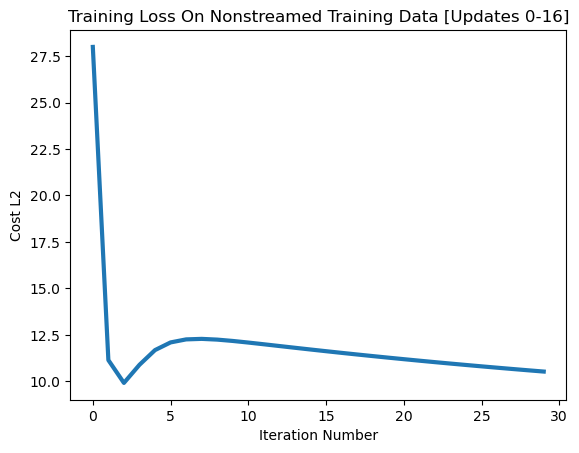

In [12]:
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(64, 2)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FullData.parameters(), lr=learning_rate)

#def full_train_linregr_updates(model, full_trial_input_data, full_trial_labels, 
#    learning_rate, lambdasFDE=[0, 1e-3, 1e-6], use_CPHSLoss=False, normalize_emg=False, PCA_comps=64, 
#    num_iters_per_update=30, normalize_V=False, starting_update=10, use_full_input_data=False, stream_data_updates=True, 
#    dt=1/60, loss_log=None, verbose=False, verbose_norms=False, return_cost_func_comps=False, update_ix=...):
trained_model_FullData, loss_log_FullData = full_train_linregr_updates(untrained_model_FullData, cli0_cond1_traindata, cli0_cond1_trainlabels, learning_rate, 
                                                                       num_iters_per_update=30, lambdasFDE=[lambdaF, lambdaD, lambdaE], 
                                                                       stream_data_updates=False, use_full_input_data=True, starting_update=0)

plt.plot(range(len(loss_log_FullData)), loss_log_FullData, linewidth=3)
plt.title("Training Loss On Nonstreamed Training Data [Updates 0-16]")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

full_train_linregr_updates Params:
learning_rate 0.0001
lambdasFDE [0, 1e-10, 1e-06]
use_CPHSLoss False
normalize_emg False
num_iters_per_update 30
starting_update 0
normalize_V False
use_full_input_data False
stream_data_updates True
return_cost_func_comps False


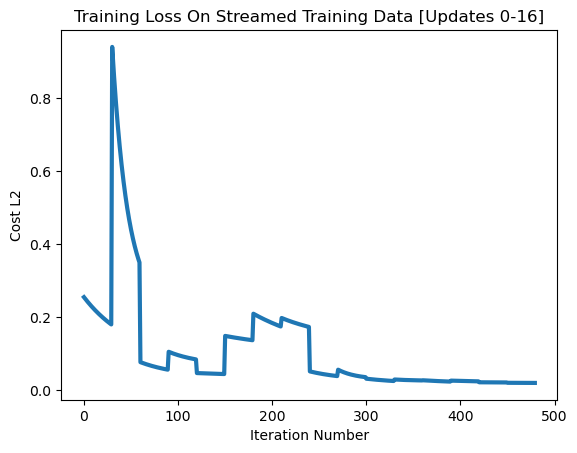

In [13]:
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(64, 2)  # Single layer nn for Lin Regr

trained_model_streamed, loss_log_streamed = full_train_linregr_updates(untrained_model_FullData, cli0_cond1_traindata, cli0_cond1_trainlabels, learning_rate, 
                                                                       num_iters_per_update=30, lambdasFDE=[lambdaF, lambdaD, lambdaE], 
                                                                       stream_data_updates=True, use_full_input_data=False, starting_update=0)

plt.plot(range(len(loss_log_streamed)), loss_log_streamed, linewidth=3)
plt.title("Training Loss On Streamed Training Data [Updates 0-16]")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

full_train_linregr_updates Params:
learning_rate 0.0001
lambdasFDE [0, 1e-10, 1e-06]
use_CPHSLoss False
normalize_emg False
num_iters_per_update 30
starting_update 10
normalize_V False
use_full_input_data False
stream_data_updates True
return_cost_func_comps False


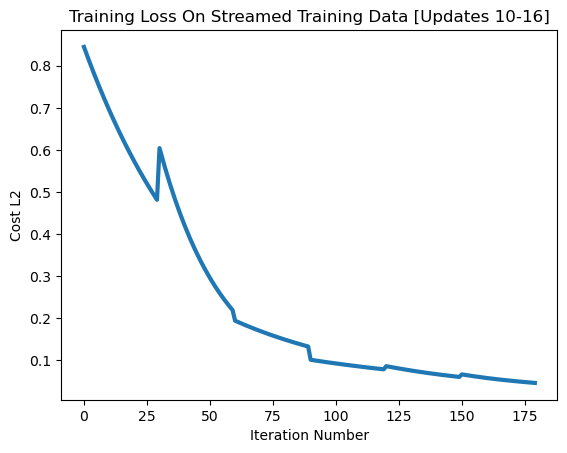

In [14]:
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(64, 2)  # Single layer nn for Lin Regr

trained_model_streamed10, loss_log_streamed10 = full_train_linregr_updates(untrained_model_FullData, cli0_cond1_traindata, cli0_cond1_trainlabels, learning_rate, 
                                                                       num_iters_per_update=30, lambdasFDE=[lambdaF, lambdaD, lambdaE], 
                                                                       stream_data_updates=True, use_full_input_data=False, starting_update=10)

plt.plot(range(len(loss_log_streamed10)), loss_log_streamed10, linewidth=3)
plt.title("Training Loss On Streamed Training Data [Updates 10-16]")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

## Using CPHSLoss

In [15]:
cli0_cond1_traindata.shape

torch.Size([19230, 64])

In [16]:
cli0_cond1_trainlabels.shape

torch.Size([19230, 2])

full_train_linregr_updates Params:
learning_rate 0.0001
lambdasFDE [0, 1e-10, 1e-06]
use_CPHSLoss True
normalize_emg False
num_iters_per_update 30
starting_update 0
normalize_V False
use_full_input_data True
stream_data_updates False
return_cost_func_comps False


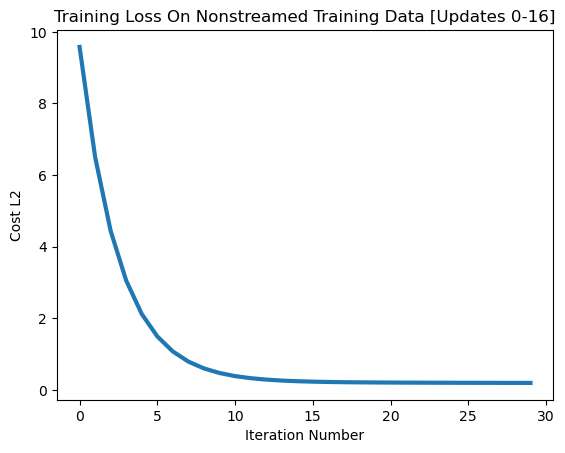

In [17]:
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(64, 2)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FullData.parameters(), lr=learning_rate)

#train/test split at update_ix[16]
cli0_cond1_traindata = torch.from_numpy(emgs_block1[keys[0]][0, :update_ix[16], :]).type(torch.float32)
cli0_cond1_trainlabels = torch.from_numpy(refs_block1[keys[0]][0, :update_ix[16], :]).type(torch.float32)
cli0_cond1_testdata = torch.from_numpy(emgs_block1[keys[0]][0, update_ix[16]:, :]).type(torch.float32)
cli0_cond1_testlabels = torch.from_numpy(refs_block1[keys[0]][0, update_ix[16]:, :]).type(torch.float32)

#def full_train_linregr_updates(model, full_trial_input_data, full_trial_labels, 
#    learning_rate, lambdasFDE=[0, 1e-3, 1e-6], use_CPHSLoss=False, normalize_emg=False, PCA_comps=64, 
#    num_iters_per_update=30, normalize_V=False, starting_update=10, use_full_input_data=False, stream_data_updates=True, 
#    dt=1/60, loss_log=None, verbose=False, verbose_norms=False, return_cost_func_comps=False, update_ix=...):
trained_model_FullData, loss_log_FullData = full_train_linregr_updates(untrained_model_FullData, cli0_cond1_traindata, cli0_cond1_trainlabels, learning_rate, 
                                                                       num_iters_per_update=30, lambdasFDE=[lambdaF, lambdaD, lambdaE], 
                                                                       stream_data_updates=False, use_full_input_data=True, starting_update=0,
                                                                       use_CPHSLoss=True)

plt.plot(range(len(loss_log_FullData)), loss_log_FullData, linewidth=3)
plt.title("Training Loss On Nonstreamed Training Data [Updates 0-16]")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

full_train_linregr_updates Params:
learning_rate 0.0001
lambdasFDE [0, 1e-10, 1e-06]
use_CPHSLoss True
normalize_emg False
num_iters_per_update 30
starting_update 0
normalize_V False
use_full_input_data False
stream_data_updates True
return_cost_func_comps False


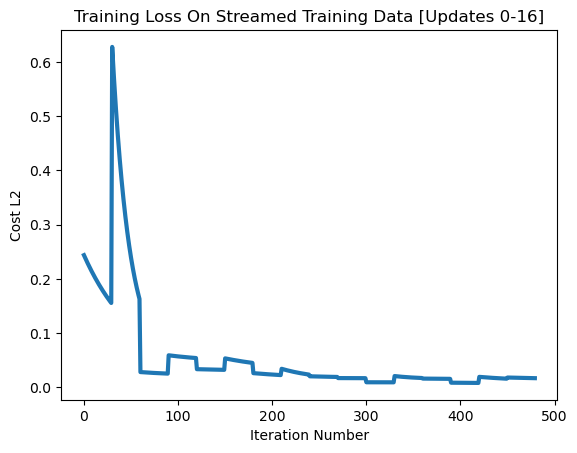

In [19]:
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(64, 2)  # Single layer nn for Lin Regr

trained_model_streamed, loss_log_streamed = full_train_linregr_updates(untrained_model_FullData, cli0_cond1_traindata, cli0_cond1_trainlabels, learning_rate, 
                                                                       num_iters_per_update=30, lambdasFDE=[lambdaF, lambdaD, lambdaE], 
                                                                       stream_data_updates=True, use_full_input_data=False, starting_update=0,
                                                                       use_CPHSLoss=True)

plt.plot(range(len(loss_log_streamed)), loss_log_streamed, linewidth=3)
plt.title("Training Loss On Streamed Training Data [Updates 0-16]")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

full_train_linregr_updates Params:
learning_rate 0.0001
lambdasFDE [0, 1e-10, 1e-06]
use_CPHSLoss True
normalize_emg False
num_iters_per_update 30
starting_update 10
normalize_V False
use_full_input_data False
stream_data_updates True
return_cost_func_comps False


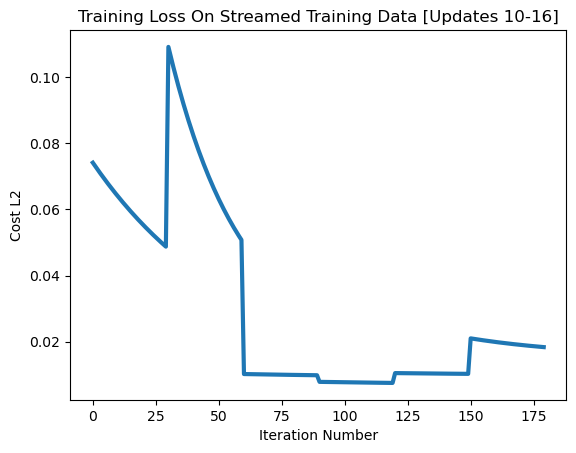

In [20]:
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(64, 2)  # Single layer nn for Lin Regr

trained_model_streamed10, loss_log_streamed10 = full_train_linregr_updates(untrained_model_FullData, cli0_cond1_traindata, cli0_cond1_trainlabels, learning_rate, 
                                                                       num_iters_per_update=30, lambdasFDE=[lambdaF, lambdaD, lambdaE], 
                                                                       stream_data_updates=True, use_full_input_data=False, starting_update=10,
                                                                       use_CPHSLoss=True)

plt.plot(range(len(loss_log_streamed10)), loss_log_streamed10, linewidth=3)
plt.title("Training Loss On Streamed Training Data [Updates 10-16]")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

In [21]:
assert(False)

AssertionError: 

## New PyTorch Only Code

In [ ]:
# our model
model = torch.nn.Linear(64, 2)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.

criterion = torch.nn.MSELoss(reduction='sum')

#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
# Making LR tiny slows it down but it still blows up...

# Training loop
i=10
for epoch in range(10):
    #for i, (x_data, y_data) in enumerate(trainloader):
    x_data = torch.tensor(emgs_block1[keys[0]][0, update_ix[i]:update_ix[i+1], :], dtype=torch.float32)
    y_data = torch.tensor(refs_block1[keys[0]][0, update_ix[i]:update_ix[i+1], :], dtype=torch.float32)
    # 1) Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x_data)

    # 2) Compute and print loss
    loss = criterion(y_pred, y_data)
    #assert(not isnan(loss))
    if isnan(loss):
        print("LOSS IS NAN")
        break
    print(f'Epoch: {epoch} | Update {i} | Loss: {loss.item()} ')

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# our model
model = torch.nn.Linear(64, 2)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.

criterion = torch.nn.MSELoss(reduction='sum')

#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
# Making LR tiny slows it down but it still blows up...

# Training loop
for epoch in range(10):
    #for i, (x_data, y_data) in enumerate(trainloader):
    for i in range(10, 16):
        x_data = torch.tensor(emgs_block1[keys[0]][0, update_ix[i]:update_ix[i+1], :], dtype=torch.float32)
        y_data = torch.tensor(refs_block1[keys[0]][0, update_ix[i]:update_ix[i+1], :], dtype=torch.float32)
        # 1) Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x_data)

        # 2) Compute and print loss
        loss = criterion(y_pred, y_data)
        #assert(not isnan(loss))
        if isnan(loss):
            print("LOSS IS NAN")
            break
        print(f'Epoch: {epoch} | Update {i} | Loss: {loss.item()} ')

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
#refs_block1, _, _, _, emgs_block1, _, _, _, _, _, _ = pickle.load(handle)
print(emgs_block1[keys[0]].shape)
print(refs_block1[keys[0]].shape)

In [ ]:
cli0_cond1_samples = emgs_block1[keys[0]][0, update_ix[10]:update_ix[11], :]
cli0_cond1_labels = refs_block1[keys[0]][0, update_ix[10]:update_ix[11], :]

In [ ]:
# our model
model = torch.nn.Linear(64, 2)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.

criterion = torch.nn.MSELoss(reduction='sum')

#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)
# Making LR tiny slows it down but it still blows up...

x_data = torch.tensor(cli0_cond1_samples, dtype=torch.float32)
y_data = torch.tensor(cli0_cond1_labels, dtype=torch.float32)

# Training loop
for epoch in range(10):
    #for i, (x_data, y_data) in enumerate(trainloader):
    
    # 1) Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x_data)

    # 2) Compute and print loss
    loss = criterion(y_pred, y_data)
    print(f'Epoch: {epoch} | Loss: {loss.item()} ')

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
for i in range(len(keys)):
    print(f"CLIENT{i}")

    # our model
    model = torch.nn.Linear(64, 2)

    # Construct our loss function and an Optimizer. The call to model.parameters()
    # in the SGD constructor will contain the learnable parameters of the two
    # nn.Linear modules which are members of the model.

    criterion = torch.nn.MSELoss(reduction='sum')

    #optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)
    # Making LR tiny slows it down but it still blows up...

    x_data = torch.tensor(emgs_block1[keys[i]][0, update_ix[10]:, :], dtype=torch.float32)
    y_data = torch.tensor(refs_block1[keys[i]][0, update_ix[10]:, :], dtype=torch.float32)

    # Training loop
    for epoch in range(10):
        #for i, (x_data, y_data) in enumerate(trainloader):

        # 1) Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x_data)

        # 2) Compute and print loss
        loss = criterion(y_pred, y_data)
        print(f'Epoch: {epoch} | Loss: {loss.item()} ')

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print()

I guess try and train an sklearn model on the data? No idea what's going on...

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
len(update_ix)

In [ ]:
def train_and_eval_sklr(emgs_block1, refs_block1, lowerbound, upperbound, test_bool=True, test_data_lb=17, test_data_ub=18):
    print(f"Lowerbound Update: {lowerbound}, Upperbound Update: {upperbound}")
    x_data = torch.tensor(emgs_block1[keys[0]][0, update_ix[lowerbound]:update_ix[upperbound], :], dtype=torch.float32)
    y_data = torch.tensor(refs_block1[keys[0]][0, update_ix[lowerbound]:update_ix[upperbound], :], dtype=torch.float32)

    reg = LinearRegression().fit(x_data, y_data)
    train_score = reg.score(x_data, y_data)
    print(f"train_score: {train_score:0.4f}")
    
    #reg.predict()
    if test_bool:
        print(f"Testing Lowerbound Update: {test_data_lb}, Testing Upperbound Update: {test_data_ub}")
        x_test = torch.tensor(emgs_block1[keys[0]][0, update_ix[test_data_lb]:update_ix[test_data_ub], :], dtype=torch.float32)
        y_test = torch.tensor(refs_block1[keys[0]][0, update_ix[test_data_lb]:update_ix[test_data_ub], :], dtype=torch.float32)
        test_score = reg.score(x_test, y_test)
        print(f"test_score: {test_score:0.4f}")
    
    print()

In [ ]:
for i in range(10,16):
    train_and_eval_sklr(emgs_block1, refs_block1, i, i+1)

In [ ]:
for i in range(10,16):
    train_and_eval_sklr(emgs_block1, refs_block1, i, 16)